# LOCATION RECOMMENDATION FOR RESTAURANT USING FOURSQUARE API AND MACHINE LEARNING

## 1.Introduction
Choosing a location for your restaurant is one of just a few keys to profitability. Parking and accessibility can be as crucial to a restaurant's success as great food and service. There is a famous saying in real estate that also holds true for restaurants: "You make your money when you buy."

A restaurant's location influences many aspects of your operation, including the menu and style of the dining room. If you already have a certain restaurant location in mind, don’t get too attached until you know if it has all the right requirements for a successful restaurant.

The classic real estate saying “location, location, location” applies to choosing a site for a new restaurant. Location influences the success or failure of a restaurant in a host of ways, from attracting enough initial customer interest to being convenient to visit. But the restaurant’s location is also interrelated to other factors, some of which are changeable, while others are not. A great restaurant location, for instance, must have an affordable rent, or it does not matter how much foot traffic the site receives.

Unfortunately, many restaurants fail within three years, and a lack of planning contributes to this hard reality. Sometimes, restaurants that would be otherwise successful go out of business because they are inaccessible or unknown to their potential customers. As might be expected, visibility and accessibility have a disproportionate effect on new restaurants that are not established yet with a core of loyal customers. Before signing a lease, restaurant owners should not get carried away with any one location until they have done their homework on the location. You must be certain that when you choose a location you are using your head as much as your heart.

We can mitigate this uncertainty through leveraging data gathered from FourSquare's API, specifically, we are able to scrape "likes" data of different restaurants directly from the API as well as their location and category of cuisine. The question we will try to address is, how accurately can we predict the amount of "likes" a new restaurant opening in this region can expect to have based on the type of cuisine it will serve and which city in it will open in. (For the purposes of this analysis, we will contain the geographical scope of analysis to three heavily populated cities in India, namely Delhi, Mumbai, and Bangalore). Leveraging this data will solve the problem as it allows the new business owner (or existing company) to make preemptive business decisions regarding opening the restaurant in terms of whether it is feasible to open one in this region and expect good social media presence, what type of cuisine and which city of three would be the best. This project will analyze and model the data via machine learning through comparing both linear and logistic regressions to see which method will yield better predictive capabilities after training and testing

## 2.DATA
Before we begin analysing the different cities for best location for opening a restraunt, we will first retrieve the geographical coordinates of the three cities (New Delhi, Mumbai and Bangalore). Then, we will use the FourSquare API to obtain URLs that'll fetch raw data in JSON form. We will scrape the raw data separately in these URLs in order to retrieve the following columns: "name", "categories", "latitude", "longitude". and "id" for each city. We can also provide another column ("city") to indicate which city the restaurants are from.

The point to keep in mind here is that the extracts are not of every restaurant in those cities but rather all of the restaurants within a 5KM range of the geographical coordinates that geolocator was able to provide. However, the extraction from the FourSquare API actually obtains venue data so it will include venues other than restaurants such as malls, stores, libraries etc. As such, this means that the data will need to be further cleaned somewhat manually by removing all of the nonrestaurant rows. Once this is complete, we have a shortened by cleaned list to pull "likes" data.The "id" is an important column as it will allow us to further pull the "likes" from the API. We can retreive the "likes" based on the restaurant "id" and then append it to the data frame. Once this is complete, we finally name the dataframe 'raw_dataset' as it is the most complete compiled form before needing any processing for analysis via machine learning.

Importing the required dependencies.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json
from pandas.io.json import json_normalize 
import requests

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim
!conda install -c conda-forge folium=0.5.0 --yes
import folium 
!conda install -c conda-forge lxml --yes
from sklearn.cluster import KMeans

from pandas.io.json import json_normalize 

from sklearn import linear_model
from sklearn.metrics import jaccard_similarity_score


import folium 

from urllib.request import urlopen


import matplotlib.pyplot as plt
import pylab as pl

from sklearn import linear_model
from sklearn.metrics import jaccard_similarity_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import log_loss
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, r2_score
import itertools


print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


Data extraction and cleaning.

In [2]:
#getting coordinates of the address
address1='Delhi,India'
location1=Nominatim(user_agent='explorer').geocode(address1)
latitude1=location1.latitude
longitude1=location1.longitude
print("coordinates of {} are {} and {} ".format(address1,latitude1,longitude1))

coordinates of Delhi,India are 28.6517178 and 77.2219388 


In [3]:
#getting coordinates of the address
address2='Mumbai,India'
location2=Nominatim(user_agent='explorer').geocode(address2)
latitude2=location2.latitude
longitude2=location2.longitude

print("coordinates of {} are {} and {} ".format(address2,latitude2,longitude2))

coordinates of Mumbai,India are 19.0759899 and 72.8773928 


In [4]:
#getting coordinates of the address
address3='Bangalore,India'
location3=Nominatim(user_agent='explorer').geocode(address3)
latitude3=location3.latitude
longitude3=location3.longitude
print("coordinates of {} are {} and {} ".format(address3,latitude3,longitude3))

coordinates of Bangalore,India are 12.9791198 and 77.5912997 


In [5]:
# define foursquare credentials and version
CLIENT_ID = 'TY0WLCQ0TKVZAHMLJPUBQTOA13CUSUKISFXRUJUCSWYLBMUE' # your Foursquare ID
CLIENT_SECRET = '0FCCSGD3JSNG0KGOFDOZ1CPI2YXS0UHAWSNO4AJXWSOAAHLL' # your Foursquare Secret
VERSION = '20180604'
LIMIT=500

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)


Your credentails:
CLIENT_ID: TY0WLCQ0TKVZAHMLJPUBQTOA13CUSUKISFXRUJUCSWYLBMUE
CLIENT_SECRET:0FCCSGD3JSNG0KGOFDOZ1CPI2YXS0UHAWSNO4AJXWSOAAHLL


In [33]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 5000 # define radius

# create URLs
url1 = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude1, 
    longitude1, 
    radius, 
    LIMIT)

url2 = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude2, 
    longitude2, 
    radius, 
    LIMIT)

url3 = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude3, 
    longitude3, 
    radius, 
    LIMIT)

print(url1, url2, url3)

https://api.foursquare.com/v2/venues/explore?&client_id=TY0WLCQ0TKVZAHMLJPUBQTOA13CUSUKISFXRUJUCSWYLBMUE&client_secret=0FCCSGD3JSNG0KGOFDOZ1CPI2YXS0UHAWSNO4AJXWSOAAHLL&v=20180604&ll=28.6517178,77.2219388&radius=5000&limit=100 https://api.foursquare.com/v2/venues/explore?&client_id=TY0WLCQ0TKVZAHMLJPUBQTOA13CUSUKISFXRUJUCSWYLBMUE&client_secret=0FCCSGD3JSNG0KGOFDOZ1CPI2YXS0UHAWSNO4AJXWSOAAHLL&v=20180604&ll=19.0759899,72.8773928&radius=5000&limit=100 https://api.foursquare.com/v2/venues/explore?&client_id=TY0WLCQ0TKVZAHMLJPUBQTOA13CUSUKISFXRUJUCSWYLBMUE&client_secret=0FCCSGD3JSNG0KGOFDOZ1CPI2YXS0UHAWSNO4AJXWSOAAHLL&v=20180604&ll=12.9791198,77.5912997&radius=5000&limit=100


In [34]:
# scrape the data from the generated URLs
results1 = requests.get(url1).json()
results1

results2 = requests.get(url2).json()
results2

results3 = requests.get(url3).json()
results3

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
### first city ###    
    
venues1 = results1['response']['groups'][0]['items']
nearby_venues1 = pd.json_normalize(venues1) # flatten JSON

# filter columns
filtered_columns1 = ['venue.name', 'venue.categories', 'venue.location.lat', 
                    'venue.location.lng', 'venue.id']
nearby_venues1 =nearby_venues1.loc[:, filtered_columns1]

# filter the category for each row
nearby_venues1['venue.categories'] = nearby_venues1.apply(get_category_type, axis=1)

# clean columns
nearby_venues1.columns = [col.split(".")[-1] for col in nearby_venues1.columns]


### second city ###

venues2 = results2['response']['groups'][0]['items']
nearby_venues2 =pd.json_normalize(venues2) # flatten JSON

# filter columns
filtered_columns2 = ['venue.name', 'venue.categories', 'venue.location.lat', 
                    'venue.location.lng', 'venue.id']
nearby_venues2 =nearby_venues2.loc[:, filtered_columns2]

# filter the category for each row
nearby_venues2['venue.categories'] = nearby_venues2.apply(get_category_type, axis=1)

# clean columns
nearby_venues2.columns = [col.split(".")[-1] for col in nearby_venues2.columns]


### third city ###

venues3 = results3['response']['groups'][0]['items']
nearby_venues3 = pd.json_normalize(venues3) # flatten JSON

# filter columns
filtered_columns3 = ['venue.name', 'venue.categories', 'venue.location.lat', 
                    'venue.location.lng', 'venue.id']
nearby_venues3 =nearby_venues3.loc[:, filtered_columns3]

# filter the category for each row
nearby_venues3['venue.categories'] = nearby_venues3.apply(get_category_type, axis=1)

# clean columns
nearby_venues3.columns = [col.split(".")[-1] for col in nearby_venues3.columns]





print('{} venues were returned by Foursquare.'.format(nearby_venues1.shape[0]))
print('{} venues were returned by Foursquare.'.format(nearby_venues2.shape[0]))
print('{} venues were returned by Foursquare.'.format(nearby_venues3.shape[0]))

100 venues were returned by Foursquare.
100 venues were returned by Foursquare.
100 venues were returned by Foursquare.


In [35]:
# add locations data to the data sets of each city

nearby_venues1['city'] = 'Delhi'
nearby_venues2['city'] = 'Mumbai'
nearby_venues3['city'] = 'Bangalore'

In [36]:

# combine the three cities into one data set

nearby_venues = nearby_venues1.copy()
nearby_venues = nearby_venues.append(nearby_venues2)
nearby_venues = nearby_venues.append(nearby_venues3)
nearby_venues.head()


,name,categories,lat,lng,id,city
0,Amritsari Lassi Wala,Snack Place,28.657325,77.224138,5662936e498e19a9801a663f,Delhi
1,Naturals Ice Cream,Ice Cream Shop,28.634455,77.222139,54783eab498e910f8bd1781d,Delhi
2,Karim's | करीम | کریم (Karim's),Indian Restaurant,28.649498,77.233691,4b42e3c7f964a520b5da25e3,Delhi
3,Haveli Dharampura,Hotel,28.653247,77.232309,56d96bfc498e2749a4ae6bf6,Delhi
4,Jolly Creations Designer Boutique,Boutique,28.662689,77.226300,4fe1cd59e4b00017d7fcbd78,Delhi


In [37]:
# check list and manually remove all non-restaurant data
nearby_venues['categories'].unique()


array(['Snack Place', 'Ice Cream Shop', 'Indian Restaurant', 'Hotel',
       'Boutique', 'Bakery', 'Plaza', 'South Indian Restaurant',
       'Coffee Shop', 'Tibetan Restaurant', 'Lounge', 'Clothing Store',
       'Monument / Landmark', 'Molecular Gastronomy Restaurant',
       'Food Truck', 'Restaurant', 'Deli / Bodega', 'Bistro', 'Bar',
       'Café', 'Asian Restaurant', 'Smoke Shop', 'Theater',
       'North Indian Restaurant', 'Spa', 'Spiritual Center',
       'Art Gallery', 'Arcade', 'Art Museum', 'Dessert Shop',
       'Sculpture Garden', 'Fast Food Restaurant', 'Donut Shop',
       'Playground', 'BBQ Joint', 'Concert Hall', 'Music Venue',
       'Pizza Place', 'Sandwich Place', 'Breakfast Spot',
       'History Museum', 'Food & Drink Shop', 'Cricket Ground',
       'Chinese Restaurant', 'Road', 'Stadium', 'Performing Arts Venue',
       'Hockey Arena', 'Miscellaneous Shop', 'Dumpling Restaurant',
       'Vegetarian / Vegan Restaurant', 'Toy / Game Store',
       'Movie Theater',

In [38]:
removal_list = ['Hotel','Boutique','Hardware Store','Mosque','Market','Paper / Office Supplies Store','Hostel','Motel',
                'Flea Market','Light Rail Station','Jewelry Store','Platform','Train Station','Road','Campground','Theme Park',
                'Bar','Deli/Bodega','Lounge','Department Store','Spa','Performing Arts Venue','Gym','Shopping Mall','Bus Station',
                'Electronic Store','Park','Cricket Ground','Clothing Store','Racetrack','Furniture/Home Store','Plaza','Brewery',
                'Toy/Game Store','Pub','Golf Course','Hotel Bar','Art Museum','Concert Hall','Nightclub','Arcade','Wine Bar','Bookstore',
                'Pool Hall','Electronics Store','Furniture / Home Store','Toy / Game Store']
nearby_venues = nearby_venues[~nearby_venues['categories'].isin(removal_list)]

nearby_venues['categories'].unique()

array(['Snack Place', 'Ice Cream Shop', 'Indian Restaurant', 'Bakery',
       'South Indian Restaurant', 'Coffee Shop', 'Tibetan Restaurant',
       'Monument / Landmark', 'Molecular Gastronomy Restaurant',
       'Food Truck', 'Restaurant', 'Deli / Bodega', 'Bistro', 'Café',
       'Asian Restaurant', 'Smoke Shop', 'Theater',
       'North Indian Restaurant', 'Spiritual Center', 'Art Gallery',
       'Dessert Shop', 'Sculpture Garden', 'Fast Food Restaurant',
       'Donut Shop', 'Playground', 'BBQ Joint', 'Music Venue',
       'Pizza Place', 'Sandwich Place', 'Breakfast Spot',
       'History Museum', 'Food & Drink Shop', 'Chinese Restaurant',
       'Stadium', 'Hockey Arena', 'Miscellaneous Shop',
       'Dumpling Restaurant', 'Vegetarian / Vegan Restaurant',
       'Movie Theater', 'Gym Pool', 'Italian Restaurant',
       'Dim Sum Restaurant', 'Irani Cafe', 'Airport Service',
       'Beer Garden', 'American Restaurant', 'Goan Restaurant',
       'Noodle House', 'Punjabi Restaurant'

In [39]:
# set up to pull the likes from the API based on venue ID
url_list = []
like_list = []
json_list = []

for i in list(nearby_venues.id):
    venue_url = 'https://api.foursquare.com/v2/venues/{}/likes?client_id={}&client_secret={}&v={}'.format(i, CLIENT_ID, CLIENT_SECRET, VERSION)
    url_list.append(venue_url)
for link in url_list:
    result = requests.get(link).json()
    likes = result['response']['likes']['count']
    like_list.append(likes)
print(like_list)


nearby_venues['likes'] = like_list
nearby_venues.head()

[6, 48, 316, 34, 174, 99, 38, 374, 15, 178, 53, 250, 89, 28, 6, 25, 37, 22, 85, 8, 31, 8, 15, 10, 7, 26, 51, 24, 12, 9, 48, 13, 23, 8, 9, 87, 31, 5, 9, 7, 12, 13, 107, 11, 4, 42, 6, 48, 415, 9, 7, 6, 7, 18, 8, 81, 17, 19, 10, 17, 87, 11, 14, 31, 7, 5, 11, 4, 4, 10, 44, 6, 6, 16, 10, 60, 4, 16, 124, 95, 285, 6, 112, 23, 78, 22, 58, 191, 14, 70, 10, 10, 8, 17, 97, 11, 10, 14, 103, 225, 12, 61, 7, 13, 8, 26, 22, 24, 10, 12, 13, 14, 18, 22, 162, 21, 66, 7, 29, 7, 14, 8, 19, 7, 33, 6, 14, 27, 16, 15, 8, 8, 16, 23, 37, 17, 207, 164, 12, 14, 9, 42, 30, 242, 15, 7, 17, 13, 21, 17, 10, 83, 126, 111, 127, 266, 483, 140, 163, 59, 16, 48, 126, 11, 230, 43, 34, 56, 14, 54, 9, 60, 12, 99, 85, 15, 133, 25, 24, 15, 12, 40, 11, 105, 29, 207, 189, 37, 27, 17, 58, 29, 19, 8, 16, 169, 11, 8, 67, 7, 6, 41, 15, 175, 24, 62, 11, 19, 12, 13, 23, 37, 6, 64, 10, 24, 11, 22]


,name,categories,lat,lng,id,city,likes
0,Amritsari Lassi Wala,Snack Place,28.657325,77.224138,5662936e498e19a9801a663f,Delhi,6
1,Naturals Ice Cream,Ice Cream Shop,28.634455,77.222139,54783eab498e910f8bd1781d,Delhi,48
2,Karim's | करीम | کریم (Karim's),Indian Restaurant,28.649498,77.233691,4b42e3c7f964a520b5da25e3,Delhi,316
6,Kake Di Hatti | काके दी हट्टी,Indian Restaurant,28.658050,77.223377,4d9d759348b6224b70c2249f,Delhi,34
7,Wenger's,Bakery,28.633412,77.218292,4e4e44902271a1bdc3ccee8d,Delhi,174


In [40]:
# this is really the raw dataset now so let us rename it something more appropriate

raw_dataset = nearby_venues
raw_dataset.head()

,name,categories,lat,lng,id,city,likes
0,Amritsari Lassi Wala,Snack Place,28.657325,77.224138,5662936e498e19a9801a663f,Delhi,6
1,Naturals Ice Cream,Ice Cream Shop,28.634455,77.222139,54783eab498e910f8bd1781d,Delhi,48
2,Karim's | करीम | کریم (Karim's),Indian Restaurant,28.649498,77.233691,4b42e3c7f964a520b5da25e3,Delhi,316
6,Kake Di Hatti | काके दी हट्टी,Indian Restaurant,28.658050,77.223377,4d9d759348b6224b70c2249f,Delhi,34
7,Wenger's,Bakery,28.633412,77.218292,4e4e44902271a1bdc3ccee8d,Delhi,174


### 2.1Preparing Data
The data needs further processing before model training and testing.The "categories" column contains too many different types of cuisines to yield any meaningful results.All of the different types of cuisine could be reclassified as European,American, Asian, drinking establishments (bars), or casual establishments such as coffee shops or ice cream parlours. We can implement manual classification as there really aren't that many different types of cuisines. As this project will compare both linear and logistic regression, it makes sense to have "likes" as both a continuous and categorical (but ordinal) variable. In the case of turning into a categorical variable, we can bin the data based on percentiles and classify them into these ordinal percentile categories.As the last stage of data preparation, it is important to note that the regressors are categorical variables (3 different cities and 6 different categories of cuisines). Hence, they require dummy variable encoding for meaningful analysis. We can accomplish this via one-hot encoding.

In [41]:
# inspecting the raw dataset shows that there may be too many different types of cuisines
raw_dataset['categories'].unique()

array(['Snack Place', 'Ice Cream Shop', 'Indian Restaurant', 'Bakery',
       'South Indian Restaurant', 'Coffee Shop', 'Tibetan Restaurant',
       'Monument / Landmark', 'Molecular Gastronomy Restaurant',
       'Food Truck', 'Restaurant', 'Deli / Bodega', 'Bistro', 'Café',
       'Asian Restaurant', 'Smoke Shop', 'Theater',
       'North Indian Restaurant', 'Spiritual Center', 'Art Gallery',
       'Dessert Shop', 'Sculpture Garden', 'Fast Food Restaurant',
       'Donut Shop', 'Playground', 'BBQ Joint', 'Music Venue',
       'Pizza Place', 'Sandwich Place', 'Breakfast Spot',
       'History Museum', 'Food & Drink Shop', 'Chinese Restaurant',
       'Stadium', 'Hockey Arena', 'Miscellaneous Shop',
       'Dumpling Restaurant', 'Vegetarian / Vegan Restaurant',
       'Movie Theater', 'Gym Pool', 'Italian Restaurant',
       'Dim Sum Restaurant', 'Irani Cafe', 'Airport Service',
       'Beer Garden', 'American Restaurant', 'Goan Restaurant',
       'Noodle House', 'Punjabi Restaurant'

In [42]:
# we can group some cuisines together to make a better categorical variable

euro = ['Pizza Place','Italian Restaurant','French Restaurant']

latino = ['Mexican Restaurant', 'Latin American Restaurant', 
          'Brazilian Restaurant', 'Taco Place']

bar = ['Cocktail Bar','Beer Bar', 'Cocktail Bar', 'Tiki Bar', 'Wine Bar', 'Hotel Bar',
       'Beer Garden', 'Speakeasy', 'Brewery', 'Pub', 'Bar', 'Gastropub',
       'Hookah Bar']

asian = ['Indian Restaurant','Tibetan Restaurant','Korean Restaurant','Indian Chinese Restaurant',
       'Mughlai Restaurant', 'Chinese Restaurant', 'Thai Restaurant',
       'Middle Eastern Restaurant','Asian Restaurant',
       'Japanese Restaurant','Afghan Restaurant',
       'Vietnamese Restaurant']

casual = ['Snack Place',
       'Dessert Shop','Fast Food Restaurant','Café','Coffee Shop','Food', 'Food Truck',
       'Deli / Bodega','Diner','Sandwich Place','Vegetarian / Vegan Restaurant', 'Tea Room','Cupcake Shop',
       'Bakery', 'Ice Cream Shop', 'Breakfast Spot','Burger Joint','Bubble Tea Shop',
       'Fried Chicken Joint']

american = ['Southern / Soul Food Restaurant', 'Food & Drink Shop', 
            'Restaurant', 'American Restaurant', 'BBQ Joint', 
            'Theme Restaurant', 'New American Restaurant',
            'Vegetarian / Vegan Restaurant', 'Seafood Restaurant']

def conditions(s):
    if s['categories'] in euro:
        return 'euro'
    if s['categories'] in latino:
        return 'latino'
    if s['categories'] in asian:
        return 'asian'
    if s['categories'] in casual:
        return 'casual'
    if s['categories'] in american:
        return 'american'
    if s['categories'] in bar:
        return 'bar'


raw_dataset['categories_classified']=raw_dataset.apply(conditions, axis=1)
raw_dataset.head()

,name,categories,lat,lng,id,city,likes,categories_classified
0,Amritsari Lassi Wala,Snack Place,28.657325,77.224138,5662936e498e19a9801a663f,Delhi,6,casual
1,Naturals Ice Cream,Ice Cream Shop,28.634455,77.222139,54783eab498e910f8bd1781d,Delhi,48,casual
2,Karim's | करीम | کریم (Karim's),Indian Restaurant,28.649498,77.233691,4b42e3c7f964a520b5da25e3,Delhi,316,asian
6,Kake Di Hatti | काके दी हट्टी,Indian Restaurant,28.658050,77.223377,4d9d759348b6224b70c2249f,Delhi,34,asian
7,Wenger's,Bakery,28.633412,77.218292,4e4e44902271a1bdc3ccee8d,Delhi,174,casual


In [43]:
# double check to make sure categories_classified has been created correctly

pd.crosstab(index=raw_dataset["categories_classified"],
            columns="count")

col_0,count
categories_classified,
american,15
asian,57
bar,3
casual,85
euro,8


In [44]:
# classify the likes into different ranking levels
print(np.percentile(raw_dataset['likes'], 33))
print(np.percentile(raw_dataset['likes'], 66))

13.0
34.66


In [45]:
def rankings(s):
    if s['likes']<=13:
        return 1
    if s['likes']<=35:
        return 2
    if s['likes']>35:
        return 3

In [46]:
raw_dataset['ranking']=raw_dataset.apply(rankings, axis=1)
raw_dataset.head()

,name,categories,lat,lng,id,city,likes,categories_classified,ranking
0,Amritsari Lassi Wala,Snack Place,28.657325,77.224138,5662936e498e19a9801a663f,Delhi,6,casual,1
1,Naturals Ice Cream,Ice Cream Shop,28.634455,77.222139,54783eab498e910f8bd1781d,Delhi,48,casual,3
2,Karim's | करीम | کریم (Karim's),Indian Restaurant,28.649498,77.233691,4b42e3c7f964a520b5da25e3,Delhi,316,asian,3
6,Kake Di Hatti | काके दी हट्टी,Indian Restaurant,28.658050,77.223377,4d9d759348b6224b70c2249f,Delhi,34,asian,2
7,Wenger's,Bakery,28.633412,77.218292,4e4e44902271a1bdc3ccee8d,Delhi,174,casual,3


In [47]:

# create dummies for linear regression modelling

# one hot encoding
reg_dataset = pd.get_dummies(raw_dataset[['categories_classified', 
                                          'city',]], 
                               prefix="", 
                               prefix_sep="")

# add name, ranking, and likes columns back to dataframe
reg_dataset['ranking'] = raw_dataset['ranking']
reg_dataset['likes'] = raw_dataset['likes']
reg_dataset['name'] = raw_dataset['name']

# move name column to the first column
reg_columns = [reg_dataset.columns[-1]] + list(reg_dataset.columns[:-1])
reg_dataset = reg_dataset[reg_columns]


reg_dataset.head()

,name,american,asian,bar,casual,euro,Bangalore,Delhi,Mumbai,ranking,likes
0,Amritsari Lassi Wala,0,0,0,1,0,0,1,0,1,6
1,Naturals Ice Cream,0,0,0,1,0,0,1,0,3,48
2,Karim's | करीम | کریم (Karim's),0,1,0,0,0,0,1,0,3,316
6,Kake Di Hatti | काके दी हट्टी,0,1,0,0,0,0,1,0,2,34
7,Wenger's,0,0,0,1,0,0,1,0,3,174


## 3. Methodology
To train and test the data, this project will use linear and logistic regression machine learning methods.Namely, linear regression will be used in an attempt to predict the number of "likes" a new restaurant in this region will have. We will utilize the Sci-Kit Learn Package to run the model. We can also utilize logisitc regression as a classification method rather than direct prediction of the number of likes. Since the number of "likes" can be binned into different categories based on different percentile bins, it is also potentiallly possible to see which range of "likes" a new restaurant in this region will have. Since the "likes" are binned into multiple (more than 2) categories, the type of logistic regression will be multinomial. Additionally, although the ranges are indeed discrete categories, they are also ordinal in nature. Therefore, the logistic regression will need to be specified as being both multinomial and ordinal. This can be done through the Sci-Kit Learn Package as well.

## 4.Results
### 4.1 Linear Regression Results
A linear regression model was trained on a random subsample of 80% of the sample and then tested on the other 20%. To see if this is a reasonable model. the residual sum of squares score and variance score were both calculated (8689 and -0.18 respectively). Given the low variance score, this is probably not a valid/good way of modelling the data. Therefore, we move on to logistic regression.

### Training and Testing

In [48]:
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
    width = 12
    height = 10
    plt.figure(figsize=(width, height))

    ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
    ax2 = sns.distplot(BlueFunction, hist=False, color="b", label=BlueName, ax=ax1)

    plt.title(Title)
    plt.xlabel('Parameters')
    plt.ylabel('Likes')

    plt.show()
    plt.close()

In [49]:
y_data=reg_dataset['likes']
x_data=reg_dataset.drop('likes',axis=1)

In [89]:


msk = np.random.rand(len(reg_dataset)) < 0.8
train = reg_dataset[msk]
test = reg_dataset[~msk]

x_train = np.asanyarray(train[['american', 'asian', 'bar', 'casual',
                         'euro','Bangalore','Delhi','Mumbai']])
y_train = np.asanyarray(train[['likes']])

x_test = np.asanyarray(test[['american', 'asian', 'bar', 'casual',
                         'euro','Bangalore','Delhi','Mumbai']])

y_test = np.asanyarray(test[['likes']])

print("number of test samples :", x_test.shape[0])
print("number of training samples:",x_train.shape[0])

number of test samples : 49
number of training samples: 169


In [90]:
from sklearn.linear_model import LinearRegression
lr=LinearRegression()
lr.fit(x_train,y_train)
# The coefficients
print ('Coefficients: ', lr.coef_)

Coefficients:  [[-4.77769930e+01 -2.34186247e+00 -2.64088397e+02 -3.22553597e+01
   1.35250563e+01 -4.38640230e+16 -4.38640230e+16 -4.38640230e+16]]


In [91]:
#prediction using trained data
yhat_train=lr.predict(x_train)

#prediction using testing data
yhat_test=lr.predict(x_test)

print("Residual sum of squares: %.2f"
      % np.mean((yhat_test - y_test) ** 2))


# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % lr.score(x_test, y_test))

Residual sum of squares: 8689.27
Variance score: -0.18


While analysing the distribution plot of the models we see the distribution of the predicted values is much different from the actual target values.
Therefore when testing the model, it doesnt perform upto the mark and hence Linear Regression is not a suitable method to evaluate this model and therefor we move to Logistic Regression.

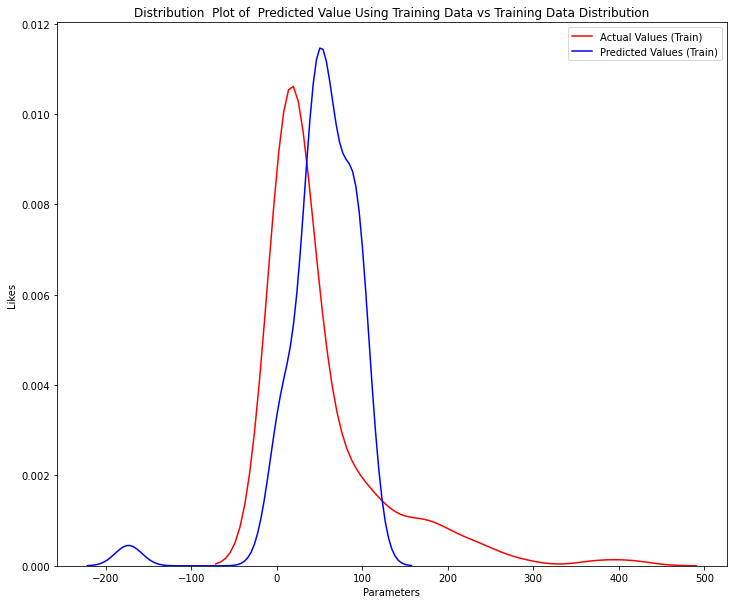

In [92]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

Title = 'Distribution  Plot of  Predicted Value Using Training Data vs Training Data Distribution'
DistributionPlot(y_train, yhat_train, "Actual Values (Train)", "Predicted Values (Train)", Title)

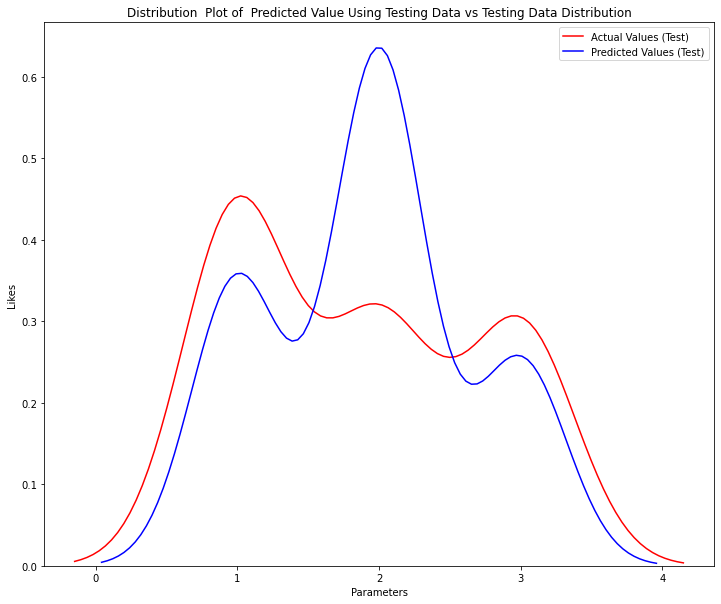

In [101]:
Title = 'Distribution  Plot of  Predicted Value Using Testing Data vs Testing Data Distribution'
DistributionPlot(y_test, yhat_test, "Actual Values (Test)", "Predicted Values (Test)", Title)

### 4.2 Logistic Regression Results
A multinomial ordinal logisitc regression model was trained on a random subsample of 80% of the sample and then tested on the other 20%. To see if this is a reasonable model, its jaccard similarity score and log-loss were calculated (0.3673 and 1.48 respectively). Although this is not a perfect prediction, a similarity of 36.73% between the training set and test set is still a better result tahn Linear Regression. The classification report is also printed later on below.

Given the modestly accurate ability of this model, we can also run the model on the full dataset. The coefficients show that opening a restaurant in Mumbai or Bangalore, serving cuisine that is american or euro in nature, are associated negatively with "likes."

In [102]:
# Multinomial Ordinal Logistic Regression

x_train = np.asanyarray(train[['american', 'asian', 'bar', 'casual','euro','Bangalore','Delhi','Mumbai']])
y_train = np.asanyarray(train['ranking'])

x_test = np.asanyarray(test[['american', 'asian', 'bar', 'casual','euro','Bangalore','Delhi','Mumbai']])
y_test = np.asanyarray(test['ranking'])


# LR = LogisticRegression(C=0.01, solver='liblinear').fit(x_train, y_train)
# LR

mul_ordinal = linear_model.LogisticRegression(multi_class='multinomial',
                                              solver='newton-cg',
                                              fit_intercept=True).fit(x_train,
                                                                      y_train)

mul_ordinal

coef = mul_ordinal.coef_[0]
print (coef)

[-0.22355026  0.0840169   0.14966242  0.06302541 -0.26326104 -0.26472625
  0.36989204 -0.10516618]


In [103]:
# Multinomial Ordinal Logistic Regression Prediction Capabilities

yhat_test = mul_ordinal.predict(x_test)
yhat_test

yhat_testprob = mul_ordinal.predict_proba(x_test)
yhat_testprob

jaccard_similarity_score(y_test, yhat_test)

0.3673469387755102

In [96]:
from sklearn.metrics import log_loss
log_loss(y_test, yhat_testprob)

1.1487870734093004

In [97]:
# Exploration of Coefficient Magnitudes of Full Dataset

x_all = np.asanyarray(reg_dataset[['american', 'asian', 'bar', 'casual',
                                   'euro','Bangalore','Delhi','Mumbai']])
y_all = np.asanyarray(reg_dataset['ranking'])



LR = linear_model.LogisticRegression(multi_class='multinomial',
                                            solver='newton-cg',
                                            fit_intercept=True).fit(x_all,
                                                                    y_all)

LR

coef = LR.coef_[0]
print (coef)

[-0.239176    0.0323088   0.08044169  0.01469987 -0.16563959 -0.30739497
  0.32589514 -0.01849857]


In [99]:
from sklearn.metrics import classification_report
print (classification_report(y_test, yhat_test))

              precision    recall  f1-score   support

           1       0.50      0.33      0.40        21
           2       0.28      0.50      0.36        14
           3       0.40      0.29      0.33        14

   micro avg       0.37      0.37      0.37        49
   macro avg       0.39      0.37      0.36        49
weighted avg       0.41      0.37      0.37        49



## 5.Discussion
The first thing to note is that given the data, logistic regression presents a better fit for the data over linear regression. Using logistic regression we were able to obtain a Jaccard Similarity Score of 36.73%, which although not perfect, is more reasonable than the low variance score obtained from the linear regression. As stated before, please note that for the purposes of this project, we are assumming that likes are a good proxy for how well a new restaurant will do in terms of brand, image and by extension how well the restaurant will perform business-wise. Whether or not these assumptions hold up in a real-life scenario is up for discussion, but this project does contain limitations in scope due to the amount of data that can be fetched from the FourSquare API.

As such, to obtain insights into this data, we can proceed with breaking down the results of the logistic regression model. The results showed that the precision score for classifying whether the new restaurant would fall into classes 1, 2, or 3 (lowest, medium, or highest percentile of likes) were 50%, 28%, and 40%. Therefore, the model is better at predicting if a restaurant will fall into the best or worst percentile of likes. This is good as we are mostly concerned with whether the restuarant will perform well or not so the high accuracy of predictions for the two extremum is a welcome feature. This allows us to fairly accurately predict the general performance of the business opportunity. Different binning methods for the classes were attempted, but the use of 3 bins by far yielded the best Jaccard Similarity Score.

Additionally, not only are we attempting to predict the general business performance but also pull insights to inform on business strategy. In this case strategy insight can be gleamed from the coefficient values from running the logistic regressin on the full dataset. As such, we can see that opening a restaurant in Mumbai or Bangalore or serving cuisine that is american or euro in nature, are associated negatively with "likes." This suggests that the business opportunity should be opening a restaurant in Delhi, with a cuisine that is Asian or casual in nature, or serves as a bar would be the best approach for maximizing likes.

## 6.Conclusion
In conclusion, after analyzing restaurant "likes" in India from 300 restaurants, we can conclude that the approach to best take in regards to maximizing business performance (as measured by "likes") is to open a restaurant that is either Asian, or casual or is a bar and that opening the venue in Delhi rather than Mumbai or Bangalore would be the best approach. Additionally, the predictive capabilities of the logistic regression prediction model are most accurate for classifying whether a restaurant will fall in either the best or worst classes when the data is binned into 3 classes.